In [14]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import glob
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt

from exp_utils import read_jeongganbo, make_jeonggan_list, JeongganProcessor, COLOR_DICT

# Load ext files and paths

**Daegeum**
* YeoMinRock score (p17~36)
* pitch names
* notations

In [16]:
reader = JeongganboReader()

ymr_infos = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

ymr = read_jeongganbo(reader, ymr_infos)

jng_list = make_jeonggan_list(reader, ymr)

pattern_path_base = 'test/daegeum/'
# pattern_path_sub = ['notations/', 'pitches/']
pattern_path_sub = ['pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

# print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

Processing pngs/daegeum_pg-017.png
No jeonggan detected at pngs/daegeum_pg-017.png
Processing pngs/daegeum_pg-018.png
No jeonggan detected at pngs/daegeum_pg-018.png
Processing pngs/daegeum_pg-019.png
No jeonggan detected at pngs/daegeum_pg-019.png
Processing pngs/daegeum_pg-020.png
Processing pngs/daegeum_pg-021.png
Processing pngs/daegeum_pg-022.png
Processing pngs/daegeum_pg-023.png
Processing pngs/daegeum_pg-024.png
Processing pngs/daegeum_pg-025.png
Processing pngs/daegeum_pg-026.png
Processing pngs/daegeum_pg-027.png
Processing pngs/daegeum_pg-028.png
Processing pngs/daegeum_pg-029.png
Processing pngs/daegeum_pg-030.png
Processing pngs/daegeum_pg-031.png
Processing pngs/daegeum_pg-032.png
Processing pngs/daegeum_pg-033.png
Processing pngs/daegeum_pg-034.png
Processing pngs/daegeum_pg-035.png
Processing pngs/daegeum_pg-036.png
['nam_d', 'hwang_u', 'nam_u', 'joong', 'tae_u', 'lim_d', 'tae', 'mu', 'joong_u', 'mu_d', 'nam', 'mu_u', 'lim_u', 'lim', 'hwang_uu', 'hwang']


# **CONSTANTS**

In [17]:
THRESHOLD = 0.5
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 47

PTRN_TEST_ORDER = ['hwang_uu', 'hwang_u', 'hwang', 'joong_u', 'joong', 'lim_u', 'lim_d', 'lim', 'mu_d', 'mu_u', 'mu', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']

PNAME_SURFIXS = ['uu, u, d, dd']

PTRN_IMG_DICT = { name: cv2.imread(pattern_paths['pitches'][name]) for name in PTRN_TEST_ORDER }

jng_processor = JeongganProcessor(PTRN_SIZE, THRESHOLD, MATCH_MODE)

target_jng_list = jng_list

In [18]:
color_list = [ color for key, color in list( filter( lambda el: '_d' not in el[0] and '_u' not in el[0], COLOR_DICT.items() ) ) ]

# Piplines

20 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(30, 5, 74, 41, 'lim_u')]}
1 {'col_div': 1, 'cols': [(32, 45, 71, 82, 'nam_u')]}
2 None


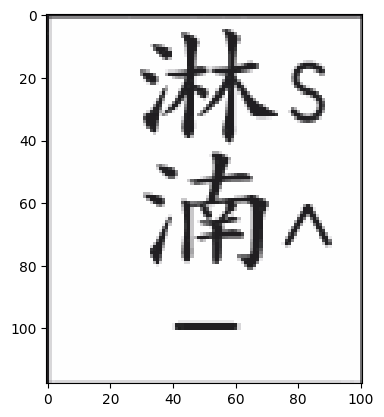

24 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 7, 75, 40, 'tae')]}
1 {'col_div': 1, 'cols': [(31, 45, 72, 81, 'joong_u')]}
2 {'col_div': 2, 'cols': [None, (57, 79, 97, 116, 'lim_u')]}


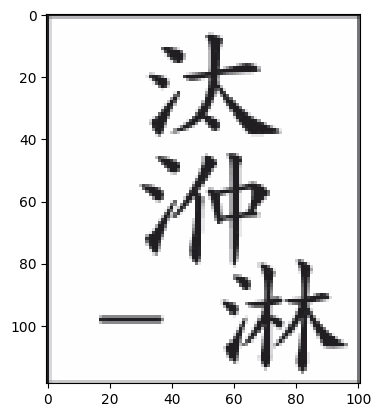

43 th jng has...
total num rows:  3
0 {'col_div': 2, 'cols': [(15, 7, 53, 44, 'joong'), (54, 8, 91, 41, 'tae')]}
1 None
2 {'col_div': 1, 'cols': [(30, 77, 72, 114, 'joong')]}


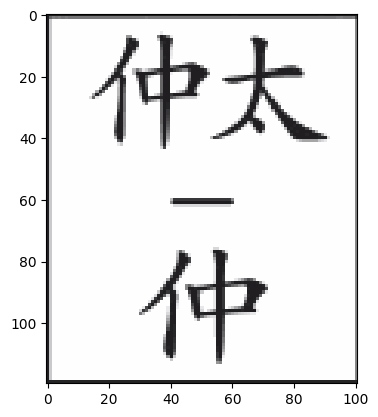

72 th jng has...
total num rows:  1
0 {'col_div': 1, 'cols': [(30, 35, 77, 78, 'lim_u')]}


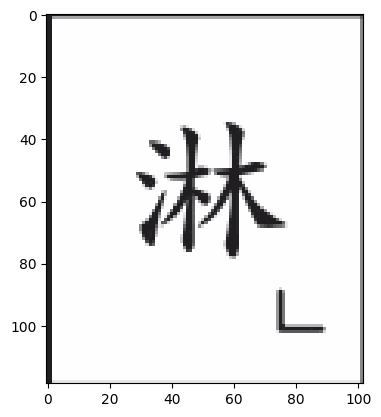

87 th jng has...
total num rows:  3
0 {'col_div': 2, 'cols': [(7, 5, 40, 43, 'nam'), (47, 7, 86, 40, 'tae')]}
1 None
2 None


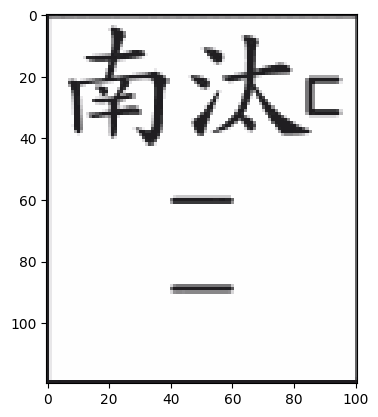

134 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 7, 75, 40, 'tae_u')]}
1 {'col_div': 1, 'cols': [(31, 45, 72, 81, 'joong_u')]}
2 None


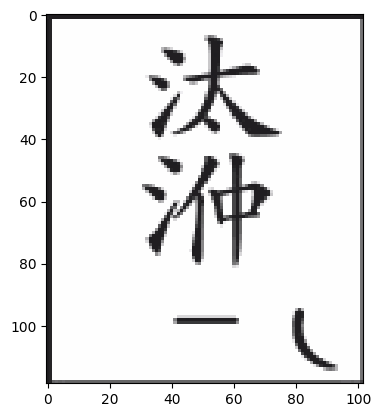

135 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(33, 8, 75, 41, 'tae_u')]}
1 {'col_div': 1, 'cols': [(32, 44, 74, 81, 'hwang_u')]}
2 None


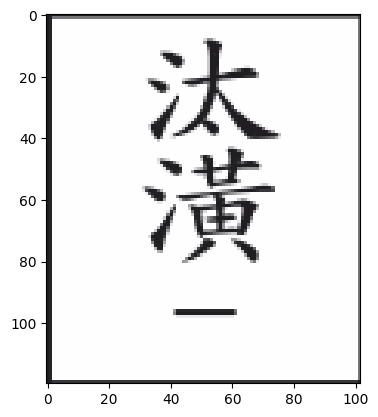

161 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(36, 5, 72, 43, 'nam')]}
1 {'col_div': 1, 'cols': [(34, 43, 78, 79, 'lim')]}
2 {'col_div': 1, 'cols': [(36, 78, 72, 116, 'nam')]}


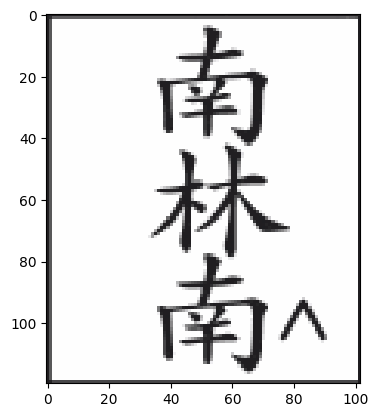

167 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(32, 5, 75, 42, 'hwang_u')]}
1 {'col_div': 2, 'cols': [None, (52, 46, 89, 79, 'tae_u')]}
2 None


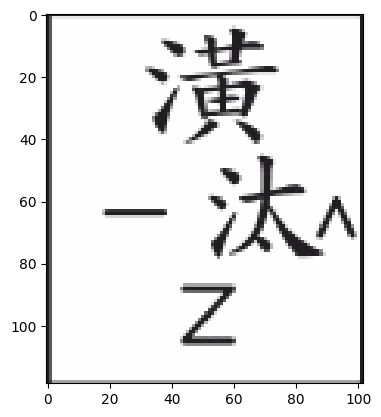

261 th jng has...
total num rows:  3
0 None
1 None
2 {'col_div': 1, 'cols': [(35, 76, 71, 114, 'nam')]}


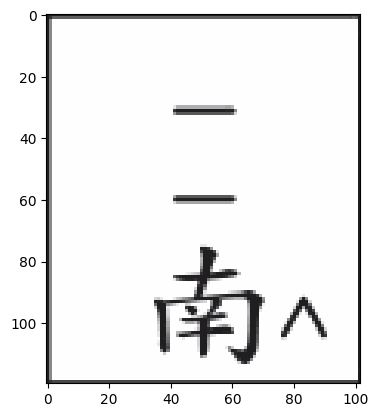

286 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(31, 5, 75, 42, 'lim')]}
1 None
2 {'col_div': 2, 'cols': [(13, 73, 46, 111, 'nam'), (51, 74, 92, 111, 'lim')]}


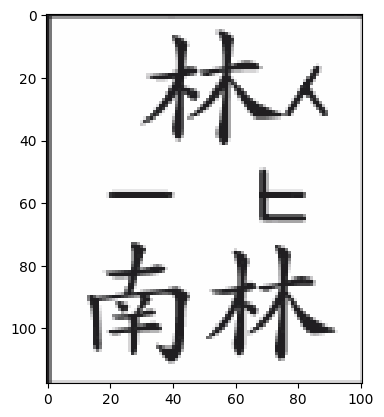

289 th jng has...
total num rows:  3
0 {'col_div': 1, 'cols': [(31, 5, 74, 42, 'hwang_u')]}
1 {'col_div': 2, 'cols': [None, (52, 35, 88, 75, 'tae')]}
2 {'col_div': 1, 'cols': [(32, 78, 74, 115, 'hwang_u')]}


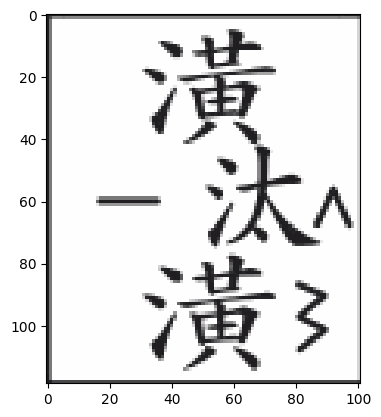

In [19]:
test_jng_idxs = [20, 24, 43, 72, 87, 134, 135, 161, 167, 261, 286, 289]

for iter_idx, jng_idx in enumerate(test_jng_idxs):
  jng_img = target_jng_list[jng_idx]
  jng_aligned_result = jng_processor(jng_img, PTRN_IMG_DICT)

  print(f'{jng_idx} th jng has...')
  print('total num rows: ', jng_aligned_result['row_div'])
  
  for row_idx, row in enumerate(jng_aligned_result['rows']):
    print(row_idx, row)
  
  plt.imshow(jng_img)
  plt.show()